# Preparing Data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
!kaggle datasets download -d maajdl/yeh-concret-data -p ../../data/

yeh-concret-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
df = pd.read_csv("../../data/Concrete_Data_Yeh.csv")

In [5]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

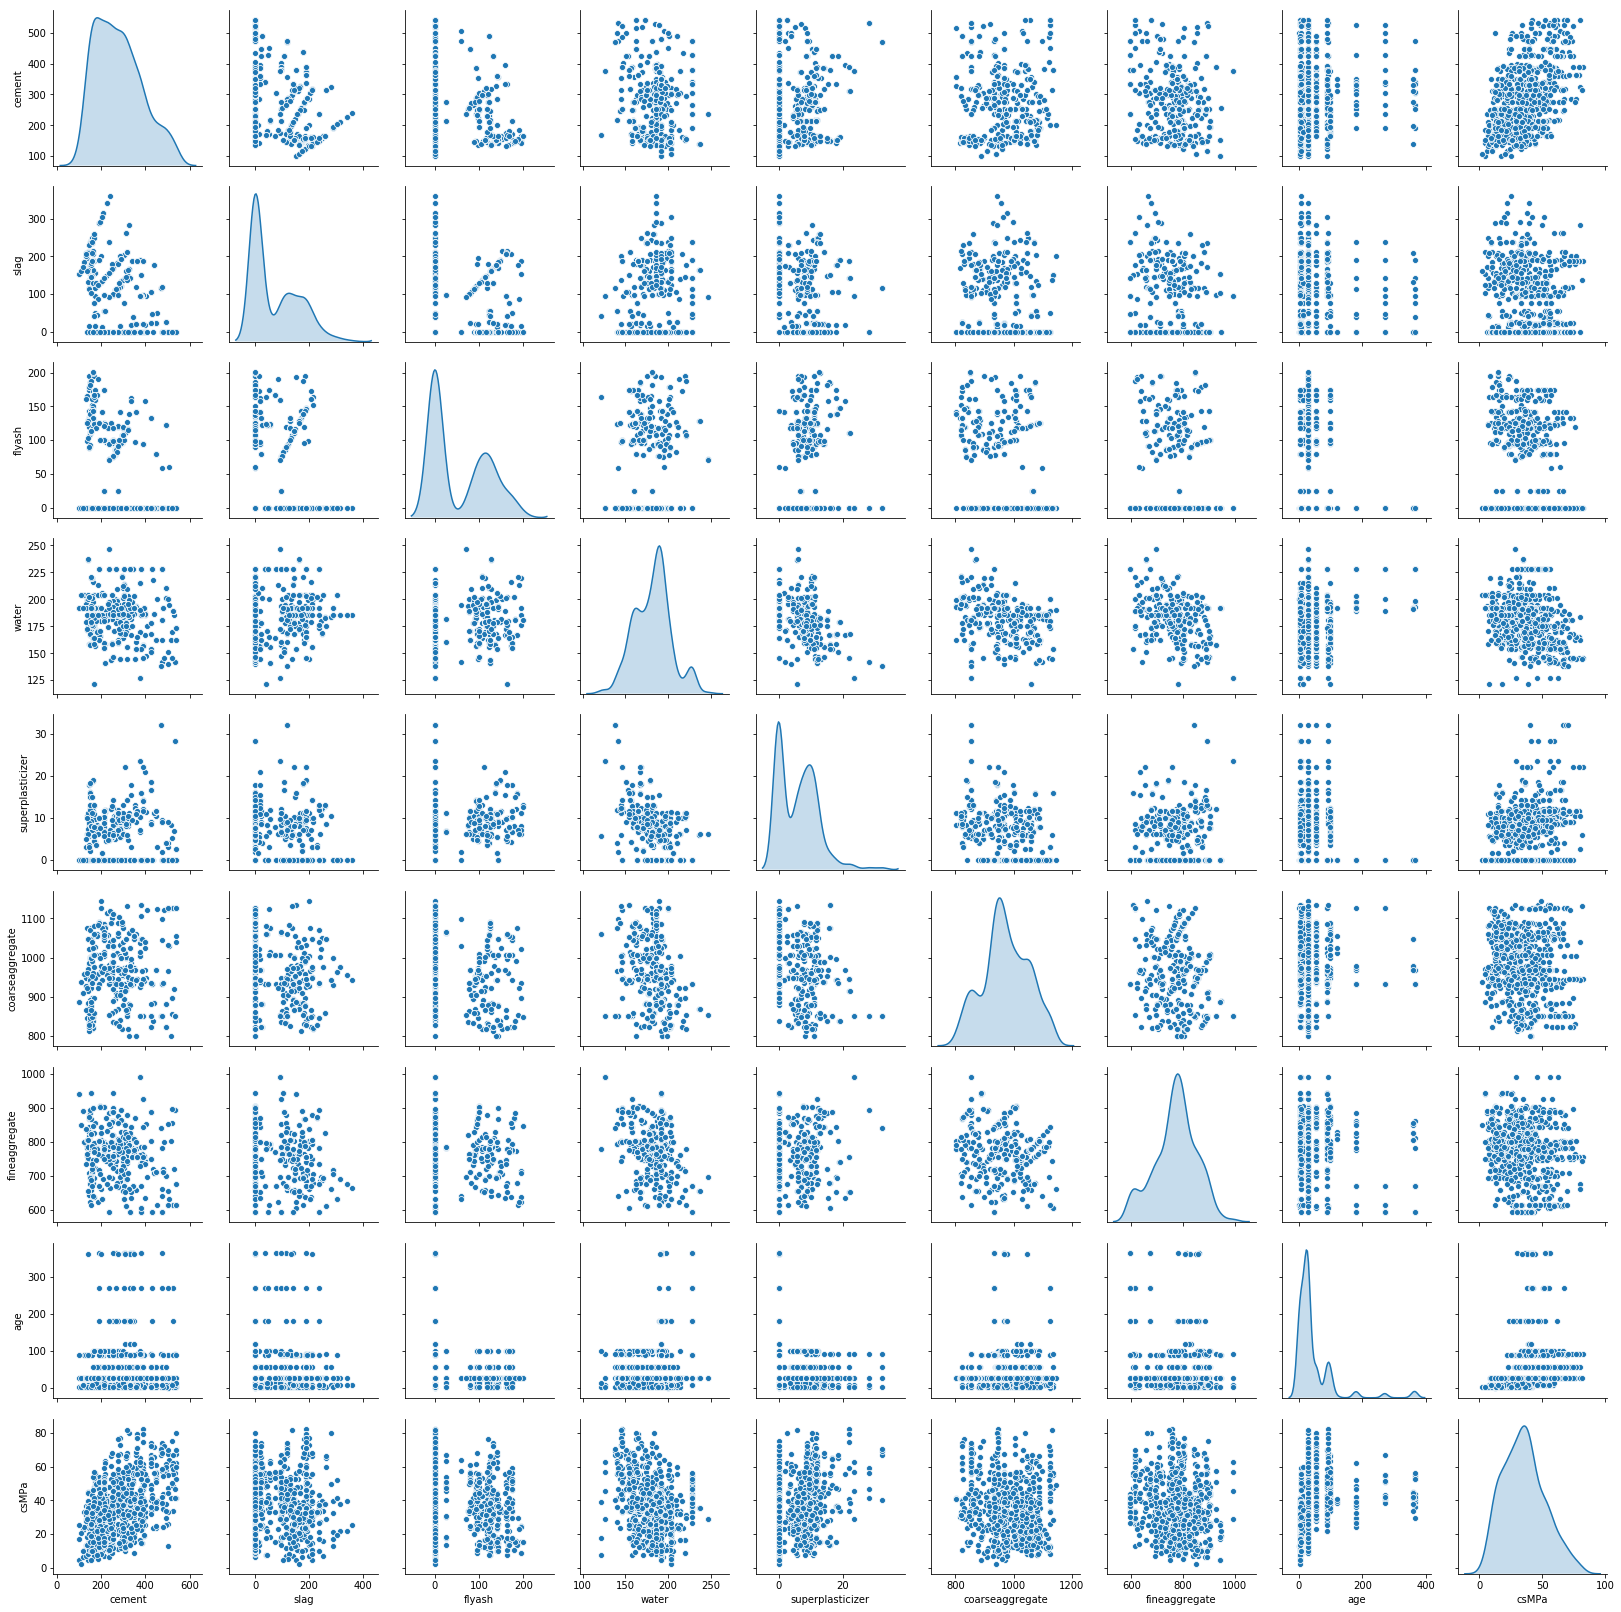

In [12]:
sns.pairplot(train_dataset, diag_kind="kde")

In [6]:
train_stats = train_dataset.describe()
train_stats.pop("csMPa")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
cement,824.0,280.272694,104.483467,102.0,193.125,266.0,350.000,540.0
slag,824.0,73.171238,85.865727,0.0,0.000,22.0,142.500,359.4
flyash,824.0,55.318325,64.098118,0.0,0.000,0.0,118.300,200.1
water,824.0,182.029490,21.287699,121.8,164.900,185.7,192.000,247.0
superplasticizer,824.0,6.147816,6.000795,0.0,0.000,6.1,10.125,32.2
coarseaggregate,824.0,973.991019,77.755840,801.0,932.000,968.0,1030.250,1145.0
fineaggregate,824.0,771.898301,80.031529,594.0,721.750,779.3,824.000,992.6
age,824.0,45.708738,63.603343,1.0,7.000,28.0,56.000,365.0


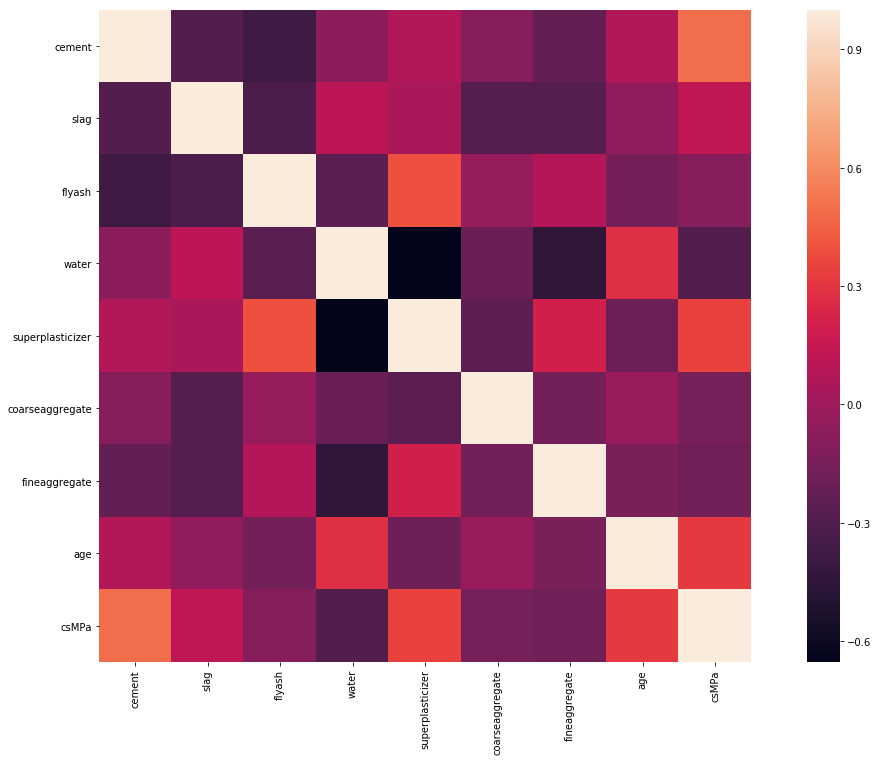

In [14]:
corr_mat = train_dataset.corr()
fig, ax = plt.subplots(figsize=(20, 12)) 
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

In [7]:
train_labels = train_dataset.pop('csMPa')
test_labels = test_dataset.pop('csMPa')

In [8]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Nearest Neighbour with sklearn

In [9]:
from sklearn.neighbors import KNeighborsRegressor

In [10]:
knn = KNeighborsRegressor(n_neighbors=10)

In [11]:
knn.fit(normed_train_data,train_labels)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [12]:
knn.score(normed_train_data,train_labels)

0.7354278586757693

In [13]:
knn.score(normed_test_data,test_labels)

0.7359637223614099

# Nearest Neighbour with tensorflow

In [14]:
from sklearn.metrics import r2_score,mean_squared_error

In [15]:
x = np.array(normed_train_data,dtype=np.float32)
y = np.array(train_labels.values,dtype=np.float32)
y = y.reshape((y.shape[0],1))

x_ = np.array(normed_test_data,dtype=np.float32)
y_ = np.array(test_labels,dtype=np.float32)
y_ = y_.reshape((y_.shape[0],1))

In [53]:
def calculate_dist(j):
    inp = tf.norm(x-j,axis=1,ord=1)
    inp = tf.nn.top_k(inp, k=5, name=None)[1]
    return tf.reduce_mean(tf.gather(y,inp)).numpy()

In [54]:
pred = []
for i in range(len(x_)):
    ans = calculate_dist(x_[i])
    pred.append(ans)
np.sqrt(mean_squared_error(y_,pred))

24.085346

In [55]:
r2_score(y_,pred)

-0.9637753578941339